<a href="https://colab.research.google.com/github/ilhamazhar1308/Rock-Type-Classification-Using-Deep-Learning-Approach-Based-on-ResNet-34-Architecture/blob/main/deeplearninggeofisika_resnet34_kelompok_4.ipynb" target="_parent"><img src="https://colab.research.google.com/assets/colab-badge.svg" alt="Open In Colab"/></a>

In [ ]:
import torch
import torch.nn as nn
import torch.optim as optim
from torchvision import datasets, transforms, models
from torch.utils.data import DataLoader
from tqdm import tqdm
import os
import numpy as np
import matplotlib.pyplot as plt
from PIL import Image
import torch.nn.functional as F
import re

In [ ]:
from google.colab import drive
drive.mount('/content/drive')

device = torch.device("cuda" if torch.cuda.is_available() else "cpu")
print("Device:", device)

Mounted at /content/drive
Device: cuda


In [ ]:
data_dir = "/content/drive/MyDrive/Rocks"
full_ds = datasets.ImageFolder(root=data_dir)

class_names = full_ds.classes
num_classes = len(class_name)

print("Jumlah kelas:", num_classes)
print("Nama kelas:", class_names)
print("Total gambar:", len(full_ds))


Jumlah kelas: 53
Nama kelas: ['Amphibolite', 'Andesite', 'Anthracite', 'Basalt', 'Blueschist', 'Breccia', 'Carbonatite', 'Chalk', 'Chert', 'Coal', 'Conglomerate', 'Diamictite', 'Dolomite', 'Eclogite', 'Evaporite', 'Flint', 'Gabbro', 'Gneiss', 'Granite', 'Granulite', 'Greenschist', 'Greywacke', 'Hornfels', 'Komatiite', 'Limestone', 'Marble', 'Migmatite', 'Mudstone', 'Obsidian', 'Oil_shale', 'Oolite', 'Pegmatite', 'Phyllite', 'Porphyry', 'Pumice', 'Pyroxenite', 'Quartz_diorite', 'Quartz_monzonite', 'Quartzite', 'Quartzolite', 'Rhyolite', 'Sandstone', 'Scoria', 'Serpentinite', 'Shale', 'Siltstone', 'Slate', 'Talc_carbonate', 'Tephrite', 'Travertine', 'Tuff', 'Turbidite', 'Wackestone']
Total gambar: 2343


In [ ]:
train_tfms = transforms.Compose([
    transforms.Resize((256,256)),
    transforms.RandomResizedCrop(224),
    transforms.RandomHorizontalFlip(),
    transforms.RandomRotation(30),
    transforms.ColorJitter(0.3,0.3,0.3),
    transforms.RandomPerspective(0.3, p=0.5),
    transforms.ToTensor(),
    transforms.Normalize([0.485,0.456,0.406],
                         [0.229,0.224,0.225])
])

test_tfms = transforms.Compose([
    transforms.Resize((224,224)),
    transforms.ToTensor(),
    transforms.Normalize([0.485,0.456,0.406],
                         [0.229,0.224,0.225])
])


In [ ]:
train_size = int(0.8 * len(full_ds))
test_size  = len(full_ds) - train_size

train_idx, test_idx = torch.utils.data.random_split(
    full_ds, [train_size, test_size]
)

train_ds = datasets.ImageFolder(data_dir, transform=train_tfms)
test_ds  = datasets.ImageFolder(data_dir, transform=test_tfms)

train_ds.samples = [full_ds.samples[i] for i in train_idx.indices]
test_ds.samples  = [full_ds.samples[i] for i in test_idx.indices]

print("Train:", len(train_ds))
print("Test :", len(test_ds))


Train: 1874
Test : 469


In [ ]:
batch_size = 32

train_dl = DataLoader(
    train_ds, batch_size=batch_size,
    shuffle=True, num_workers=2, pin_memory=True
)

test_dl = DataLoader(
    test_ds, batch_size=batch_size,
    shuffle=False, num_workers=2, pin_memory=True
)


In [ ]:
model = models.resnet34(
    weights=models.ResNet34_Weights.IMAGENET1K_V1
)

# Freeze
for param in model.parameters():
    param.requires_grad = False

# Ganti FC
model.fc = nn.Sequential(
    nn.Linear(512, 256),
    nn.BatchNorm1d(256),
    nn.ReLU(),
    nn.Dropout(0.5),
    nn.Linear(256, num_classes)
)

# Fine tuning layer terakhir
for name, param in model.named_parameters():
    if "layer4" in name:
        param.requires_grad = True

model = model.to(device)


Downloading: "https://download.pytorch.org/models/resnet34-b627a593.pth" to /root/.cache/torch/hub/checkpoints/resnet34-b627a593.pth


100%|██████████| 83.3M/83.3M [00:00<00:00, 174MB/s]


In [ ]:
criterion = nn.CrossEntropyLoss(label_smoothing=0.15)

optimizer = optim.AdamW(
    filter(lambda p: p.requires_grad, model.parameters()),
    lr=1e-4, weight_decay=1e-3
)


In [ ]:
def accuracy(logits, y):
    return (logits.argmax(1) == y).float().mean().item()


In [ ]:
def train_one_epoch(model, loader):
    model.train()
    loss_sum, acc_sum = 0, 0

    for x, y in tqdm(loader, desc="Train", leave=False):
        x, y = x.to(device), y.to(device)

        optimizer.zero_grad()
        out = model(x)
        loss = criterion(out, y)
        loss.backward()
        optimizer.step()

        loss_sum += loss.item() * x.size(0)
        acc_sum  += accuracy(out, y) * x.size(0)

    return loss_sum / len(loader.dataset), acc_sum / len(loader.dataset)


In [ ]:
ckpt_dir = "/content/drive/MyDrive/Checkpoints_Rocks_FINAL"
os.makedirs(ckpt_dir, exist_ok=True)

epochs = 40
for ep in range(1, epochs + 1):
    loss, acc = train_one_epoch(model, train_dl)

    print(f"Epoch {ep:03d} | Loss {loss:.4f} | Acc {acc*100:.2f}%")

    if ep % 5 == 0:
        torch.save({
            "epoch": ep,
            "model": model.state_dict(),
            "optimizer": optimizer.state_dict()
        }, f"{ckpt_dir}/checkpoint_{ep}.pth")

        print("✅ Checkpoint saved")


KeyboardInterrupt: 

In [ ]:
ckpt_dir = "/content/drive/MyDrive/Checkpoints_Rocks_FINAL"

def extract_epoch(fname):
    return int(re.search(r"checkpoint_(\d+)\.pth", fname).group(1))

checkpoint_files = [
    f for f in os.listdir(ckpt_dir) if f.endswith(".pth")
]

assert len(checkpoint_files) > 0, "Checkpoint tidak ditemukan!"

checkpoint_files.sort(key=extract_epoch)

latest_ckpt = os.path.join(ckpt_dir, checkpoint_files[-1])
print("Memuat checkpoint:", latest_ckpt)

checkpoint = torch.load(latest_ckpt, map_location=device)

model.load_state_dict(checkpoint["model"])
optimizer.load_state_dict(checkpoint["optimizer"])

start_epoch = checkpoint["epoch"] + 1
print("Lanjut dari epoch:", start_epoch)

epochs = 70

for ep in range(start_epoch, epochs + 1):
    loss, acc = train_one_epoch(model, train_dl)

    print(f"Epoch {ep:03d} | Loss {loss:.4f} | Acc {acc*100:.2f}%")

    if ep % 5 == 0:
        torch.save({
            "epoch": ep,
            "model": model.state_dict(),
            "optimizer": optimizer.state_dict()
        }, f"{ckpt_dir}/checkpoint_{ep}.pth")

        print("✅ Checkpoint saved")


Memuat checkpoint: /content/drive/MyDrive/Checkpoints_Rocks_FINAL/checkpoint_40.pth
Lanjut dari epoch: 41


Epoch 041 | Loss 1.8632 | Acc 72.09%


Epoch 042 | Loss 1.8188 | Acc 74.71%


Epoch 043 | Loss 1.8481 | Acc 72.73%


Epoch 044 | Loss 1.7901 | Acc 75.83%


Epoch 045 | Loss 1.8057 | Acc 73.43%
✅ Checkpoint saved


Epoch 046 | Loss 1.7775 | Acc 75.24%


Epoch 047 | Loss 1.7907 | Acc 75.35%


Epoch 048 | Loss 1.7630 | Acc 75.24%


Epoch 049 | Loss 1.7353 | Acc 76.31%


Epoch 050 | Loss 1.7177 | Acc 76.52%
✅ Checkpoint saved


Epoch 051 | Loss 1.7425 | Acc 76.57%


Epoch 052 | Loss 1.7349 | Acc 75.61%


Epoch 053 | Loss 1.7023 | Acc 77.80%


Epoch 054 | Loss 1.6782 | Acc 78.50%


Epoch 055 | Loss 1.6967 | Acc 77.69%
✅ Checkpoint saved


Epoch 056 | Loss 1.6798 | Acc 78.23%


Epoch 057 | Loss 1.6635 | Acc 79.40%


Epoch 058 | Loss 1.6800 | Acc 78.60%


Epoch 059 | Loss 1.6417 | Acc 80.04%


Epoch 060 | Loss 1.6591 | Acc 78.71%
✅ Checkpoint saved


Epoch 061 | Loss 1.6442 | Acc 78.71%


Epoch 062 | Loss 1.6535 | Acc 78.39%


Epoch 063 | Loss 1.6278 | Acc 79.30%


Epoch 064 | Loss 1.6265 | Acc 80.42%


Epoch 065 | Loss 1.6084 | Acc 80.42%
✅ Checkpoint saved


Epoch 066 | Loss 1.6425 | Acc 81.11%


Epoch 067 | Loss 1.6071 | Acc 80.90%


Epoch 068 | Loss 1.5822 | Acc 81.59%


Epoch 069 | Loss 1.6018 | Acc 79.72%


Epoch 070 | Loss 1.6437 | Acc 78.66%
✅ Checkpoint saved


In [ ]:
ckpt = torch.load(f"{ckpt_dir}/checkpoint_{epochs}.pth",
                  map_location=device)

model.load_state_dict(ckpt["model"])
print("Checkpoint loaded, siap prediksi")


Checkpoint loaded, siap prediksi


In [ ]:
def extract_epoch(fname):
    return int(re.search(r"checkpoint_(\d+)\.pth", fname).group(1))

ckpt_files = [f for f in os.listdir(ckpt_dir) if f.endswith(".pth")]
ckpt_files.sort(key=extract_epoch)

latest_ckpt = os.path.join(ckpt_dir, ckpt_files[-1])
print("Loading:", latest_ckpt)

ckpt = torch.load(latest_ckpt, map_location=device)
model.load_state_dict(ckpt["model"])

print("✅ Checkpoint terakhir dimuat, siap prediksi")


Loading: /content/drive/MyDrive/Checkpoints_Rocks_FINAL/checkpoint_55.pth
✅ Checkpoint terakhir dimuat, siap prediksi


In [ ]:
import matplotlib.pyplot as plt
from PIL import Image
import torch.nn.functional as F
import os

def predict_image_with_photo(img_path, topk=5):
    assert os.path.exists(img_path), "File gambar tidak ditemukan"

    model.eval()
    img = Image.open(img_path).convert("RGB")

    # Transform
    x = test_tfms(img).unsqueeze(0).to(device)

    with torch.no_grad():
        logits = model(x)
        probs = F.softmax(logits, dim=1)[0]


    topk_vals, topk_idx = probs.topk(topk)


    plt.figure(figsize=(6,6))
    plt.imshow(img)
    plt.axis("off")

    plt.title(
        f"PREDIKSI: {class_name[topk_idx[0]]}\n"
        f"CONFIDENCE: {topk_vals[0]*100:.2f}%"
    )

    plt.show()


    print("TOP PREDIKSI:")
    for i, v in zip(topk_idx, topk_vals):
        print(f"{class_name[i]:<25} {v*100:.2f}%")

    if topk_vals[0] < 0.90:
        print("⚠️ Model kurang yakin")

    return class_name[topk_idx[0]]


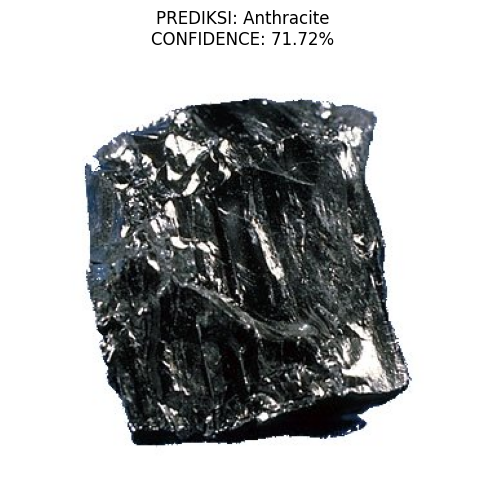

TOP PREDIKSI:
Anthracite                71.72%
Coal                      10.58%
Hornfels                  0.89%
Siltstone                 0.80%
Flint                     0.60%
⚠️ Model kurang yakin


'Anthracite'

In [ ]:
predict_image_with_photo(
    "/content/drive/MyDrive/DEEPLEARN/testbatu2.jpg"
)
